#**Multimodal Emotion Recognition from Audio and Transcript**

# Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.utils.class_weight import compute_class_weight


### Set parameters


In [2]:
SAMPLE_RATE = 22050
N_MELS = 128
MAX_LEN = 173
NUM_CLASSES = 8  # Number of emotion classes
TOP_DB = 20

# Loading Audio


### Mounting google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzipping the folder

In [4]:
!unzip "/content/drive/My Drive/RAVDESS/audio_files.zip" -d "/content/drive/My Drive/RAVDESS/"


Archive:  /content/drive/My Drive/RAVDESS/audio_files.zip
replace /content/drive/My Drive/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/drive/My Drive/RAVDESS/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /con

## Creating list of all audio files

In [5]:
ravdess_dir = "/content/drive/My Drive/RAVDESS/"
wav_files = []
for root, dirs, files in os.walk(ravdess_dir):
    if 'Actor_' in root and 'audio_speech' not in root:
        for file in files:
            if file.endswith(".wav"):
                wav_files.append(os.path.join(root, file))
print(f"Total files found: {len(wav_files)}")

Total files found: 1440


###  Plays the Audio file(for testing)

In [6]:
ipd.Audio(wav_files[0])

# Dealing with the raw data

## Function to extract emotion


In [7]:
def extract_emotion(filename):
    # filename: "03-01-06-01-02-01-12.wav"
    parts = filename.split('-')
    emotion = int(parts[2])  # 3rd part is emotion
    return emotion - 1  # Make it zero-based (0-7)

## Function to extract features


In [8]:
def extract_melspectrogram(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    y_trimmed = librosa.effects.trim(y, top_db=TOP_DB)[0]

    # Audio augmentation moved outside real-time pipeline
    S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=N_MELS)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Padding before normalization
    if S_dB.shape[1] < MAX_LEN:
        pad_width = MAX_LEN - S_dB.shape[1]
        S_dB = np.pad(S_dB, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        S_dB = S_dB[:, :MAX_LEN]

    # Per-channel normalization
    S_normalized = (S_dB - np.mean(S_dB, axis=0)) / (np.std(S_dB, axis=0) + 1e-8)
    return S_normalized

## Visualisation plot

In [9]:
def plot_melspectrogram(file_path, title="Mel Spectrogram"):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    y_trimmed, _ = librosa.effects.trim(y, top_db=TOP_DB)

    # Plot waveform
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y_trimmed, sr=sr)
    plt.title('Trimmed Waveform')

    # Compute and plot mel spectrogram
    S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=N_MELS*2)
    S_db_mel = librosa.power_to_db(S, ref=np.max)

    plt.subplot(2, 1, 2)
    img = librosa.display.specshow(S_db_mel,
                                  x_axis='time',
                                  y_axis='mel',
                                  sr=sr,
                                  fmax=8000)
    plt.colorbar(img, format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

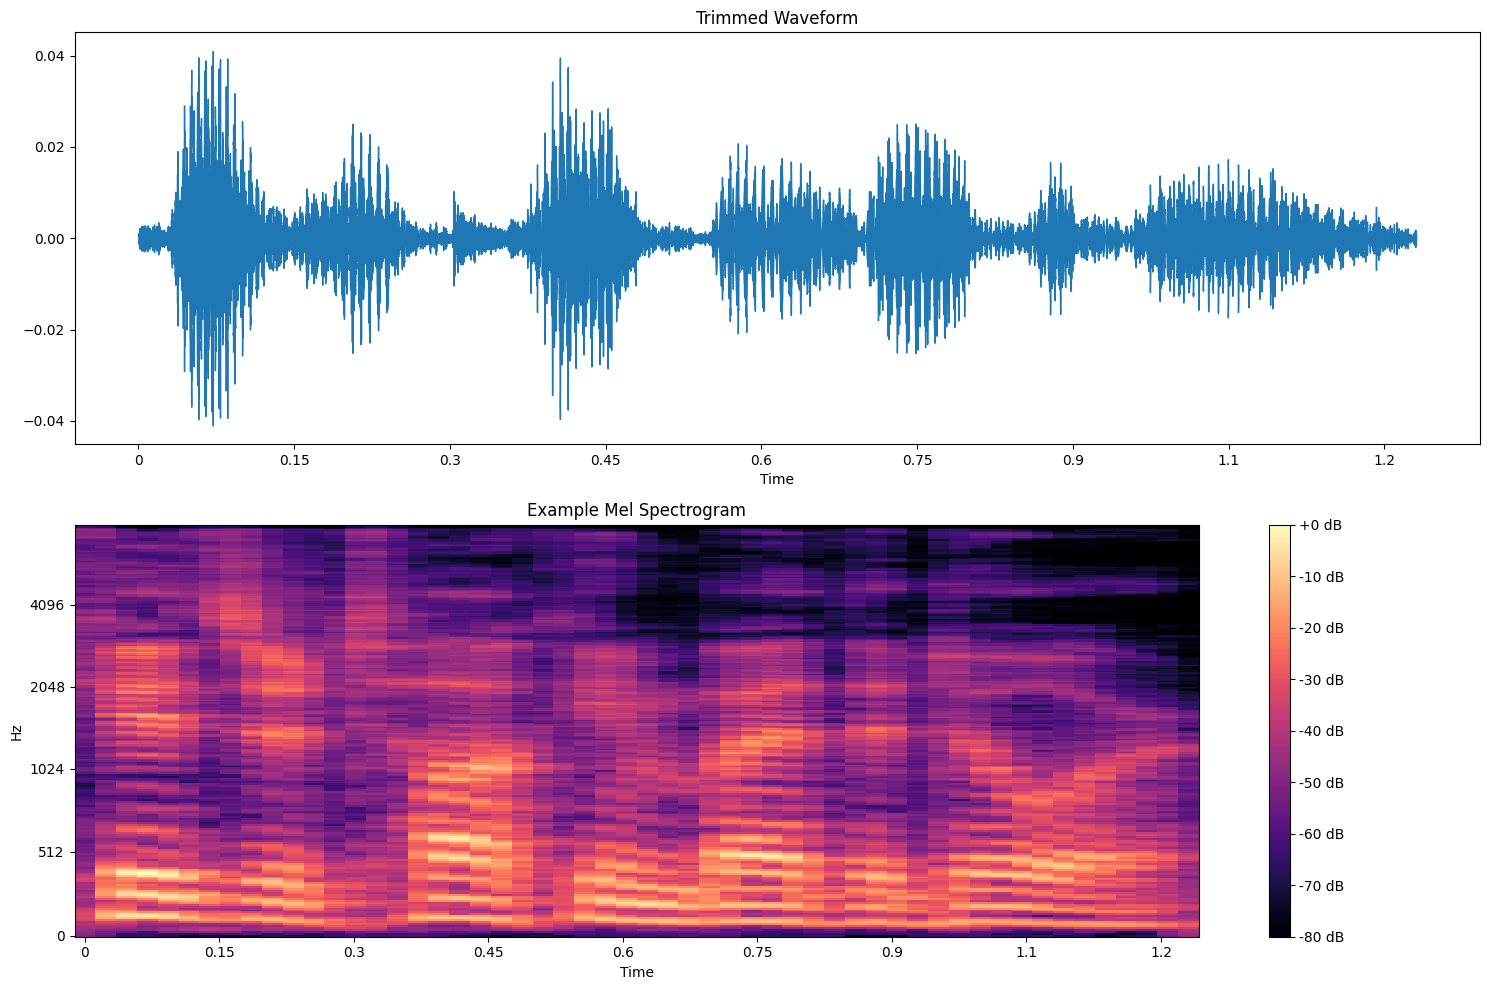

In [10]:
plot_melspectrogram(wav_files[0], "Example Mel Spectrogram")

## Data Augmentation


In [11]:
def augment_audio(y, sr):
    # Random noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.005, len(y))
        y = y + noise
    # Pitch shift
    if np.random.rand() > 0.5:
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-3,3))
    # Time stretch
    if np.random.rand() > 0.5:
        rate = np.random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=rate)
    return y

## Load Data and Labels

In [12]:
X = []
y_labels = []

for i, file_path in enumerate(wav_files):
    # Base version
    S_dB = extract_melspectrogram(file_path)
    X.append(S_dB)
    y_labels.append(extract_emotion(file_path))
X = np.array(X)
y = np.array(y_labels)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1440, 128, 173)
y shape: (1440,)


In [13]:
X = X[..., np.newaxis]  # Add channel dimension
y_cat = to_categorical(y, num_classes=NUM_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

X_mean = np.mean(X_train)
X_std = np.std(X_train)
X_train = (X_train - X_mean)/X_std
X_test = (X_test - X_mean)/X_std
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1152, 128, 173, 1) (1152, 8)
Test shape: (288, 128, 173, 1) (288, 8)


In [14]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# CNN part of the code

Epoch 1/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.1953 - loss: 2.1929 - val_accuracy: 0.1181 - val_loss: 2.2165
Epoch 2/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3376 - loss: 1.8765 - val_accuracy: 0.0660 - val_loss: 2.5095
Epoch 3/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3935 - loss: 1.7177 - val_accuracy: 0.0660 - val_loss: 3.3945
Epoch 4/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4346 - loss: 1.6017 - val_accuracy: 0.0660 - val_loss: 4.8241
Epoch 5/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4565 - loss: 1.5096 - val_accuracy: 0.1111 - val_loss: 6.4315
Epoch 6/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4930 - loss: 1.4880 - val_accuracy: 0.1319 - val_loss: 7.5240
Epoch 7/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5454 - loss: 1.3504 - val_accuracy: 0.0729 - val_loss: 8.0675
Epoch 8/16
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5637 - loss: 1.2739 - val_accuracy: 0.1285 - v

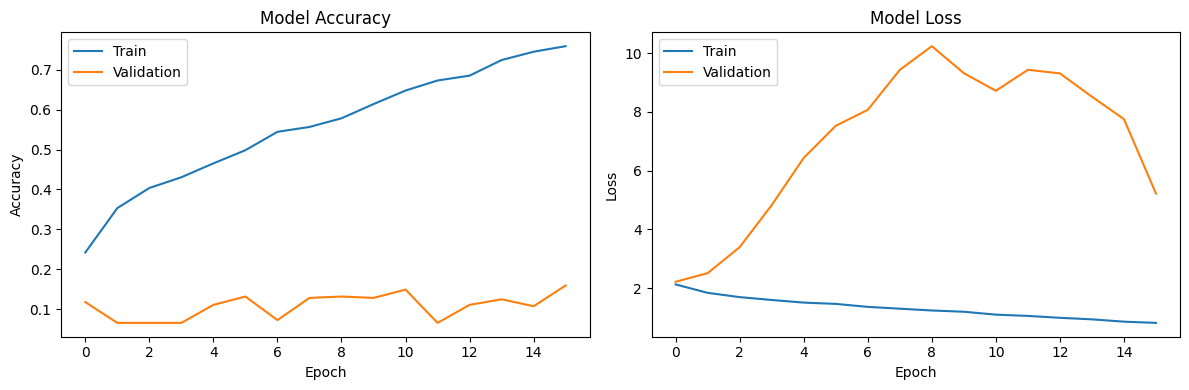

In [20]:
model = Sequential([
    Input(shape=(N_MELS, MAX_LEN, 1)),

    # Input normalization layer
    BatchNormalization(),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),

    # Added dropout for regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])

initial_lr = 0.001
lr_schedule = ExponentialDecay(
    initial_lr,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True
)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
]

history = model.fit(
    X_train, y_train,
    epochs=16,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save model
model.save('ravdess_emotion_cnn.keras')